# StructN2V - 2D Example for Synthetic Membrane Data

Clean signal simulated/provided by [Alex Dibrov]("Alexandr Dibrov" <dibrov@mpi-cbg.de>)

In [1]:
# We import all our dependencies
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data, autocorrelation
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


# Training Data Preparation

In [33]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
dataPath="data/gt.npy"
if not os.path.exists(dataPath):
    _ = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/9LawR2GwE5WGrxw/download', dataPath)
X = np.load(dataPath).astype(np.float32)

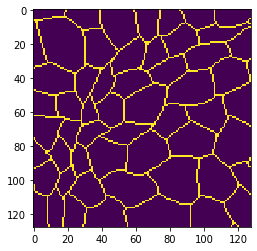

In [34]:
plt.imshow(X[0]) ## clean signal simulated fluorescent cell membranes in 2D epithelium

In [35]:
## compute the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) for each 2D image
xautocorr = np.array([autocorrelation(_x) for _x in X])

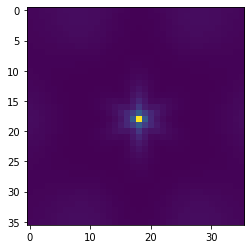

In [36]:
## notice faint hexagonal symmetry of cells

x = xautocorr.mean(0)
def crop_square_center(x,w=20):
    a,b = x.shape
    x = x[a//2-w:a//2+w,b//2-w:b//2+w]
    return x
plt.imshow(crop_square_center(x,18))

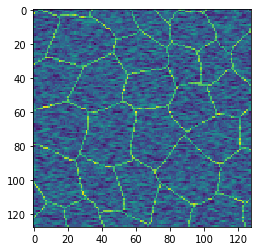

In [37]:
## generate synthetic structured noise by convolving pixelwise independent noise with a small 3x1 kernel.
## Then add this noise to the clean signal to generate our `noisy_dataset`.

from scipy.ndimage import convolve

purenoise = []
noise_kernel  = np.array([[1,1,1]])/3 ## horizontal correlations
a,b,c = X.shape
for i in range(a):
    noise = np.random.rand(b,c)*1.5
    noise = convolve(noise,noise_kernel)
    purenoise.append(noise)
purenoise = np.array(purenoise)
purenoise = purenoise - purenoise.mean()
    
noisy_dataset = X + purenoise
plt.imshow(noisy_dataset[20])

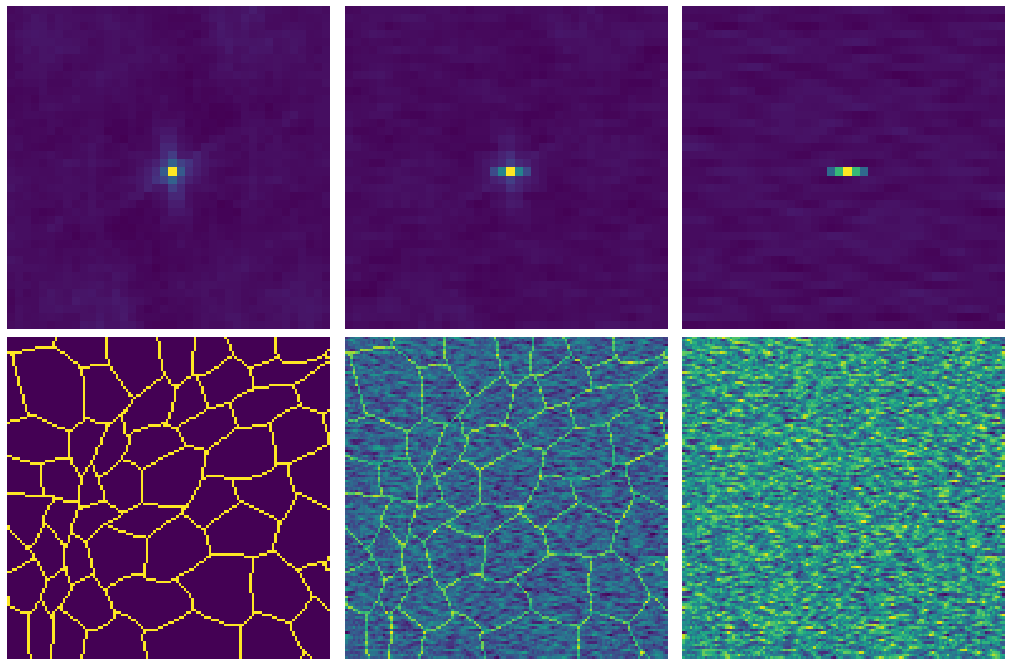

In [29]:
## Autocorrelation (top row) vs Data (bottom row)
## Notice how the autocorrelation of the noise (far right) reveals the horizontal shape of `noise_kernel` used above.
## Also see how the autocorrelation of the `noisy_dataset` (center top) is a combination of that of the signal and the noise?

fig,axs = plt.subplots(2,3, gridspec_kw = {'wspace':0.025, 'hspace':0.025}, figsize=(18,12))

def ac_and_crop(x):
    x = autocorrelation(x)
    a,b = x.shape
    x = x[a//2-20:a//2+20, b//2-20:b//2+20]
    return x

x1,x2,x3 = ac_and_crop(X[0]), ac_and_crop(noisy_dataset[0]), ac_and_crop(purenoise[0])
axs[0,0].imshow(x1)
axs[0,1].imshow(x2)
axs[0,2].imshow(x3)
axs[1,0].imshow(X[0])
axs[1,1].imshow(noisy_dataset[0])
axs[1,2].imshow(purenoise[0])

for a in axs.flat: a.axis('off')

In [10]:
## shuffle and randomly split the data into training and validation sets
inds = np.arange(X.shape[0])
np.random.shuffle(inds)
X_val   = noisy_dataset[inds[:800]][...,None]
X_train = noisy_dataset[inds[800:]][...,None]

# Configure

In [47]:
config = N2VConfig(X_train, unet_kern_size=3, 
                   train_steps_per_epoch=10, train_epochs=30, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='normal_withoutCP', n2v_neighborhood_radius=2,
                   structN2Vmask = [[0,1,1,1,1,1,0]]) ## mask should be wide enough to cover most of the noise autocorrelation

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.08523914313310618'],
 'stds': ['0.3256461372238057'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 30,
 'train_steps_per_epoch': 10,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'normal_withoutCP',
 'n2v_neighborhood_radius': 2,
 'structN2Vmask': [[0, 1, 1, 1, 1, 1, 0]],
 'probabilistic': False}

In [48]:
# a name used to identify the model
model_name = 'structn2v_membrane_sim_normal_withoutCP'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)
model.prepare_for_training(metrics=())

/lustre/projects/project-broaddus/n2v/n2v/models/n2v_standard.py:410: UserWarning: output path for model already exists, files may be overwritten: /lustre/projects/project-broaddus/n2v/examples/2D/structN2V_2D_synth_mem/models/structn2v_membrane_sim_normal_withoutCP
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [49]:
# We are ready to start training now.
history = model.train(X_train, X_val)

Preparing validation data:   0%|          | 0/800 [00:00<?, ?it/s]

StructN2V Mask is:  [[0 1 1 1 1 1 0]]
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 800/800 [00:01<00:00, 693.31it/s]


Epoch 1/30
10/10 [==============================] - 8s 819ms/step - loss: 1.5953 - val_loss: 2.3281
Epoch 2/30
10/10 [==============================] - 7s 693ms/step - loss: 0.8217 - val_loss: 2.3097
Epoch 3/30
10/10 [==============================] - 7s 680ms/step - loss: 0.6588 - val_loss: 1.3995
Epoch 4/30
10/10 [==============================] - 7s 695ms/step - loss: 0.6095 - val_loss: 1.7212
Epoch 5/30
10/10 [==============================] - 7s 696ms/step - loss: 0.5620 - val_loss: 1.0155
Epoch 6/30
10/10 [==============================] - 7s 696ms/step - loss: 0.5379 - val_loss: 0.7413
Epoch 7/30
10/10 [==============================] - 7s 697ms/step - loss: 0.5335 - val_loss: 0.7353
Epoch 8/30
10/10 [==============================] - 7s 683ms/step - loss: 0.5200 - val_loss: 0.7227
Epoch 9/30
10/10 [==============================] - 7s 698ms/step - loss: 0.4911 - val_loss: 0.7108
Epoch 10/30
10/10 [==============================] - 7s 685ms/step - loss: 0.4926 - val_loss: 0.6174

### After training, lets plot training and validation loss.

['loss', 'lr', 'val_loss']


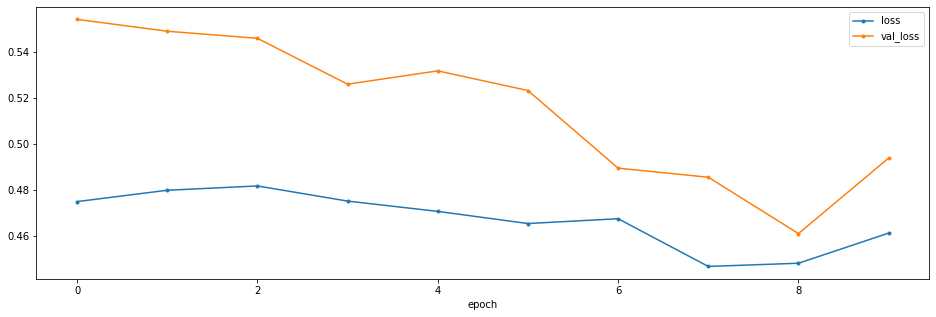

In [43]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# Compute PSNR to GT

In [38]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(1.0) - 10 * np.log10(mse)

In [44]:
pred = []
psnrs = []
for gt, img in zip(X, noisy_dataset):
    p_ = model.predict(img.astype(np.float32), 'YX');
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)
pred = np.array(pred)

In [46]:
print("PSNR:  {:.3f} {:.3f}".format(psnrs.mean(), psnrs.std()))
print("-------------------")
print("Means: {:.3f} {:.3f} {:.3f}".format(X.mean(),noisy_dataset.mean(),pred.mean()))
print("Stds:  {:.3f} {:.3f} {:.3f}".format(X.std(),noisy_dataset.std(),pred.std()))

PSNR:  15.018 0.684
-------------------
Means: 0.085 0.085 0.070
Stds:  0.279 0.376 0.222


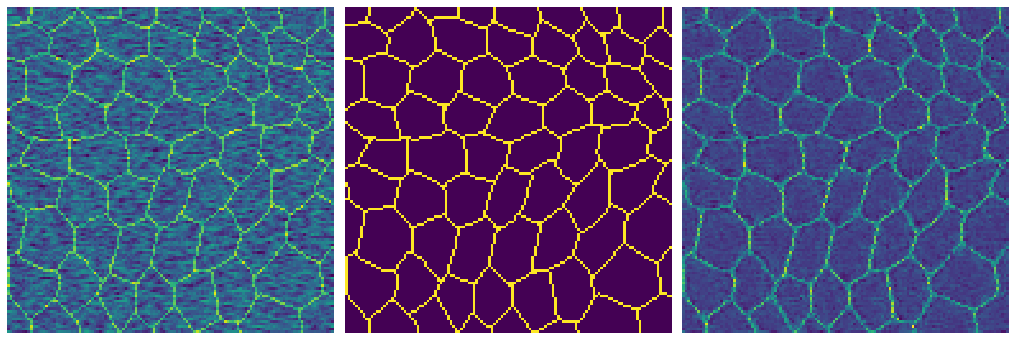

In [45]:
fig,axs = plt.subplots(1,3,figsize=(6*3,6))
axs[0].imshow(noisy_dataset[2], interpolation='nearest')
axs[1].imshow(X[2], interpolation='nearest')
axs[2].imshow(pred[2], interpolation='nearest')

fig.subplots_adjust(wspace=0.025, hspace=0.025)
for a in axs.flat: a.axis('off')